# Kod narzedzia do rysowania


In [1]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.

from typing import List
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import random
import heapq
import functools
from sortedcontainers import SortedSet
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                w_x = abs(self.ax.get_xlim()[1] - self.ax.get_xlim()[0])
                w_y = abs(self.ax.get_ylim()[1] - self.ax.get_ylim()[0])
                tolerated_dist = np.sqrt(w_x**2 + w_y**2) * TOLERANCE
                
                if dist(self.rect_points[0], new_point) < tolerated_dist:
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                    if self.watch_polygons and len(self.added_rects) > 0:
                        self.watch_polygons = True
                        self.draw(autoscaling = True)
                        plt.close()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

In [2]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()

## Funkcje pomocnicze

In [3]:
%matplotlib notebook

def det(a,b,c):
    return (a.x * b.y) + (a.y * c.x) + (b.x * c.y) - (c.x * b.y)- (b.x * a.y) - (a.x * c.y)

def det2(a, b):
    return a[0] * b[1] - a[1] * b[0]

def get_lines(plot):
    return list(map(lambda l: Line(Point(l[0][0], l[0][1]), Point(l[1][0], l[1][1])), plot.get_added_lines()[-1].lines))
    
def orientation(a, b, c, e=10**-14):
    d = det(a, b, c)
    if d > e:
        return 1
    if d < -e:
        return -1
    else:
        return d


def make_lines(n,lower_left, upper_right):
    res = []
    for i in range(0, n):
        p1 = Point(random.uniform(lower_left.x, upper_right.x), random.uniform(lower_left.y, upper_right.y))
        p2 = Point(random.uniform(lower_left.x, upper_right.x), random.uniform(lower_left.y, upper_right.y))
        if p1.y == p2.y:
            i = i - 1
            continue
        res.append(Line(p1, p2))
    res.sort(key=lambda l: l.get_slope())
    res_dist = [res[0]]
    for i in range(1, len(res)):
        if res[i - 1].collinear(res[i]):
            res_dist.append(res[i])
    return res_dist

def intersection(line1, line2):
    a = line1.get_left().x - line1.get_right().x, line2.get_left().x - line2.get_right().x
    b = line1.get_left().y - line1.get_right().y, line2.get_left().y - line2.get_right().y
    div = det2(a, b)
    d = (det2(*line1.to_tuple()), det2(*line2.to_tuple()))
    x = det2(d, a) / div
    y = det2(d, b) / div
    if line1.get_left().x < x < line1.get_right().x and \
            line2.get_left().x < x < line2.get_right().x:
        point = Point(x,y)
        point.add_intersecting_lines(line1, line2)
        return point
    return None

## Struktury pomocnicze


In [4]:
class Point:

    def __init__(self, x,y):
        self.x = x
        self.y = y

    def add_intersecting_lines(self, line1, line2):
        self.line1=line1
        self.line2=line2

    def get_y(self, x):
        return self.y

    def __eq__(self, other):
        return isinstance(other, Point) and self.x == other.x and self.y == other.y

    def __hash__(self):
        return self.x.__hash__()*self.y.__hash__()

    def __gt__(self, other):
        return isinstance(other, Point) and self.x > other.x

    def __ge__(self, other):
        return isinstance(other, Point) and self.x >= other.x

    def __le__(self, other):
        return isinstance(other, Point) and self.x <= other.x

    def __lt__(self, other):
        return isinstance(other, Point) and self.x < other.x

    def __str__(self):
        return '(' + str(self.x) + ', ' + str(self.y) + ')'
    
    def to_tuple(self):
        return self.x, self.y

class Line:

    def __init__(self, p1, p2):
        if p1.x < p2.x:
            self.p1 = p1
            self.p2 = p2
        else:
            self.p1 = p2
            self.p2 = p1

    def get_left(self):
        return self.p1

    def get_right(self):
        return self.p2

    def get_slope(self):
        return (self.p2.y - self.p1.y) / (self.p2.x - self.p1.x)

    def get_b(self):
        return self.p2.y - self.get_slope() * self.p2.x

    def get_y(self, x: float):
        return self.get_slope() * x + self.get_b()

    def collinear(self, line ):
        a1 = self.get_slope()
        b1 = self.get_b()
        a2 = line.get_slope()
        b2 = line.get_b()
        return a1 != a2 and b1 != b2

    def __str__(self):
        return '(' + str(self.p1) + ', ' + str(self.p2) + ')'

    def to_tuple(self):
        return self.get_left().to_tuple(), self.get_right().to_tuple()

## Algorytm sprawdzania czy jest przecięcie

In [5]:
class detectIntersection:
    def __init__(self, dataSet, scenes):
        self.events = SortedSet(key=lambda p:-p.x)
        self.lines = SortedSet()
        self.data = {}
        for l in dataSet:
            self.data[l.get_left()] = l
            self.data[l.get_right()] = l
            self.events.add(l.get_left())
            self.events.add(l.get_right())
        self.scenes = scenes
        self.dataSet = dataSet
    
    def event_update(self, event):
        if event in self.data.keys():
            d = self.data[event]
            if event == d.get_left():
                self.scenes.append(Scene([PointsCollection([event.to_tuple()], color='red'),],[LinesCollection(list(map(lambda l: l.to_tuple(), self.dataSet))), LinesCollection([ ((event.x, self.low_y()), (event.x, self.top_y())) ], color='red')]))
                return self.start_update(event, d)
            else:
                self.scenes.append(Scene([PointsCollection([event.to_tuple()], color='red'),  ],[LinesCollection(list(map(lambda l: l.to_tuple(), self.dataSet))), LinesCollection([ ((event.x, self.low_y()), (event.x, self.top_y())) ], color='red')]))
                return self.end_update(event, d)  
    
            
    def start_update(self, e, line):
        self.refresh(e.x)
        return self.insert(line)
        
    def end_update(self, e, line):
        self.refresh(e.x)
        return self.pop_line(line)
        
   
    def refresh(self, x):
        s = SortedSet(key=lambda s: (s.get_slope() * x + s.get_b()))
        s.update(self.lines)
        self.lines = s
    
    def insert(self, line):
        self.lines.add(line)
        index = self.lines.index(line)
        if index - 1 >= 0:
            line_down = self.lines[index-1]
            return self.get_cross(line_down, line)
        if index + 1 < len(self.lines):
            line_up = self.lines[index+1]
            return self.get_cross(line, line_up)
    
    def low_y(self):
        return functools.reduce(lambda a, b: b if b.y < a.y else a, self.data.keys()).y
    
    def top_y(self):
        return functools.reduce(lambda a, b: b if b.y > a.y else a, self.data.keys()).y
        
    def pop_line(self, line):
        index = self.lines.index(line)
        if index - 1 >= 0 and index + 1 < len(self.lines):
            line_down = self.lines[index-1]
            line_up = self.lines[index+1]
            return self.get_cross(line_down, line_up)
        self.lines.remove(line)
        
    def start(self):
        while len(self.events) > 0:
            event = self.events.pop()
            if self.event_update(event):
                return True
        return False
    
   
    def get_cross(self, line1, line2):
        l1_left = line1.get_left()
        l1_right = line1.get_right()
        l2_left = line2.get_left()
        l2_right = line2.get_right()
        
        if orientation(l1_left, l1_right, l2_left) != orientation(l1_left, l1_right, l2_right) and orientation(l2_left, l2_right, l1_left)!=orientation(l2_left, l2_right, l1_right):
            return True
        else:
            return False
        
        
        

True


<IPython.core.display.Javascript object>


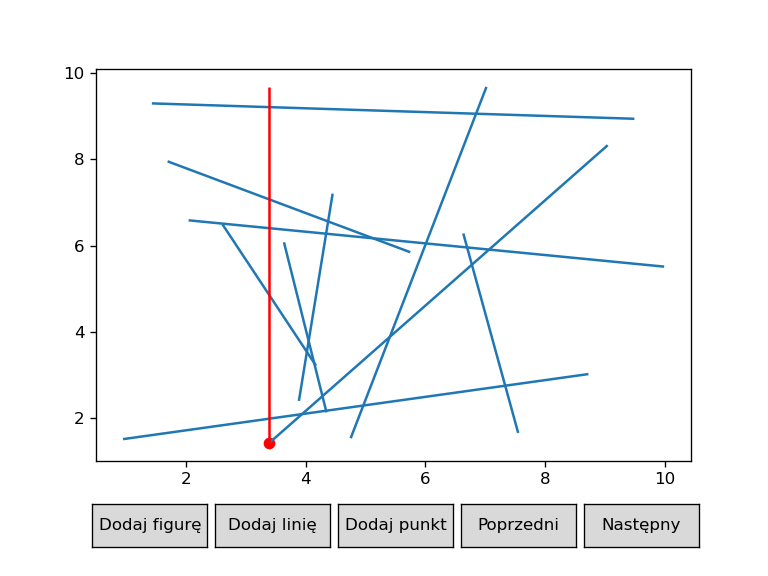

In [21]:


%matplotlib notebook
dataset = make_lines(10,Point(0,0),Point(10,10))
scenes = []
sweeper = detectIntersection(dataset, scenes)
print(sweeper.start())

plot1 = Plot(scenes)
plot1.draw()

## Algorytm znajdywania wszystkich przecięć

In [9]:

class findIntersections:
    def __init__(self, scenes=[]):
       
        self.scenes = scenes
        self.data = {}
        self.results = set([])
        self.events= SortedSet(key=lambda p:-p.x)
        self.lines= SortedSet()


    def check_event(self, event: Point):
        if event in self.data:
            line = self.data[event]
            if event == line.get_left():
                self.refresh(event.x)
                self.add_line(line)
            else:
                self.refresh(event.x)
                self.pop_line(line)
        else:
            self.cross(event)

    

    def add_line(self, line: Line):
        self.lines.add(line)
        i = self.lines.index(line)

        if i - 1 >= 0 and i + 1 < len(self.lines):
            cross = self.get_cross(self.lines[i - 1], self.lines[i + 1])
            if cross is not None and cross in self.events:
                self.events.remove(cross)
        if i - 1 >= 0:
            cross = self.get_cross(self.lines[i - 1], line)
            if cross is not None and cross not in self.results and cross not in self.events:
                self.events.add(cross)
        if i + 1 < len(self.lines):
            cross = self.get_cross(line, self.lines[i + 1])
            if cross is not None and cross not in self.results and cross not in self.events:
                self.events.add(cross)
                
    
                

    def pop_line(self, line):
        i = self.lines.index(line)
        if i - 1 >= 0 and i + 1 < len(self.lines):
            cross = self.get_cross(self.lines[i - 1], self.lines[i + 1])
            if cross is not None and cross not in self.results:
                self.events.add(cross)
        self.lines.remove(line)
        
    def start(self, data):
        for l in data:
            self.data[l.get_left()] = l
            self.data[l.get_right()] = l
            self.events.add(l.get_left())
            self.events.add(l.get_right())
        low_y = functools.reduce(lambda acc, p: p if p.y<acc.y else acc, self.data.keys()).y
        high_y = functools.reduce(lambda acc, p: p if p.y>acc.y else acc, self.data.keys()).y
        self.refresh(self.events[0].x)
        while len(self.events)>0:
            event = self.events.pop()
            self.scenes.append(Scene( [PointsCollection([event.to_tuple()], color='red'), PointsCollection(list(map(lambda l: l.to_tuple(), self.results)))],[LinesCollection(list(map(lambda l: l.to_tuple(), dataset))), LinesCollection([ ((event.x, low_y), (event.x, high_y)) ], color='red')]))
            self.check_event(event)
        return self.results
    
    def refresh(self, x):
        temp_lines = SortedSet(key=lambda l: l.get_y(x))
        temp_lines.update(self.lines)
        self.lines = temp_lines

    def cross(self, cross):
        self.results.add(cross)
        line1 = cross.line1
        line2 = cross.line2

        self.pop_line(line1)
        self.pop_line(line2)

        self.refresh(cross.x + 0.01)

        self.add_line(line1)
        self.add_line(line2)

    
    
    def get_cross(self, line1, line2):
        return intersection(line1, line2)

    

Number of intersections 8
Point (4.694616713562629, 5.714733737371759)
Line ((4.332913449487173, 5.583037099440556), (6.913572410523816, 6.522658448128896)) ((3.066733330624026, 6.650669547820316), (9.28048714083875, 3.0781318775893816))
Point (0.3524453608447044, 0.7281480469853958)
Line ((0.18064482345582, 0.326583140731902), (3.493325666113215, 8.069611144295818)) ((0.30427883021220126, 0.7141820315023484), (9.097282631514163, 3.2637372022583833))
Point (9.004469230441213, 3.236825706259035)
Line ((0.30427883021220126, 0.7141820315023484), (9.097282631514163, 3.2637372022583833)) ((3.066733330624026, 6.650669547820316), (9.28048714083875, 3.0781318775893816))
Point (2.6614668779970656, 6.125232498320644)
Line ((0.18064482345582, 0.326583140731902), (3.493325666113215, 8.069611144295818)) ((1.3046819751320904, 5.648618528866361), (4.778594500705944, 6.868941097944563))
Point (5.840770724207635, 5.055763571514147)
Line ((1.756053065452533, 4.029033112711687), (6.640622388923925, 5.256

<IPython.core.display.Javascript object>


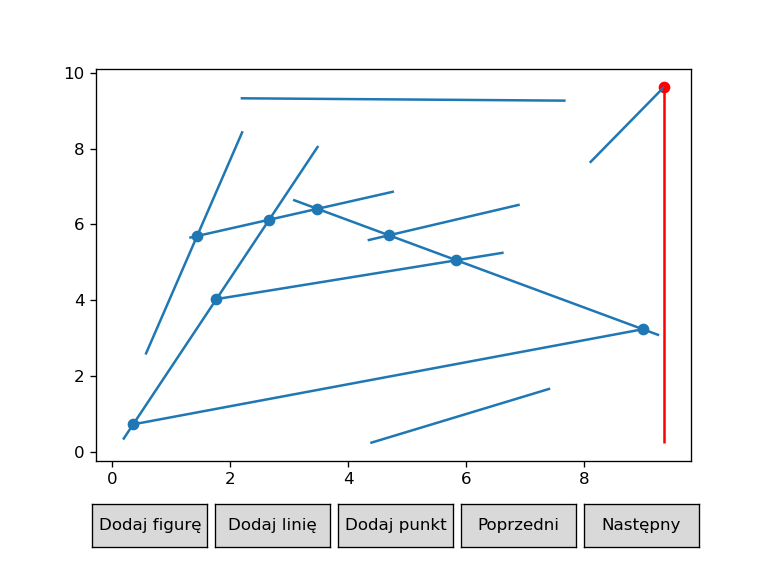

In [22]:
%matplotlib notebook
scenes = []
sweep = findIntersections(scenes)
dataset = make_lines(10,Point(0,0),Point(10,10))
result = sweep.start(dataset)
print('Number of intersections ' + str(len(result)))
for p in result:
    print('Point ' + str(p))
    print('Line ' + str(p.line1) + ' ' + str(p.line2))
plot = Plot(scenes)
plot.draw()


<IPython.core.display.Javascript object>


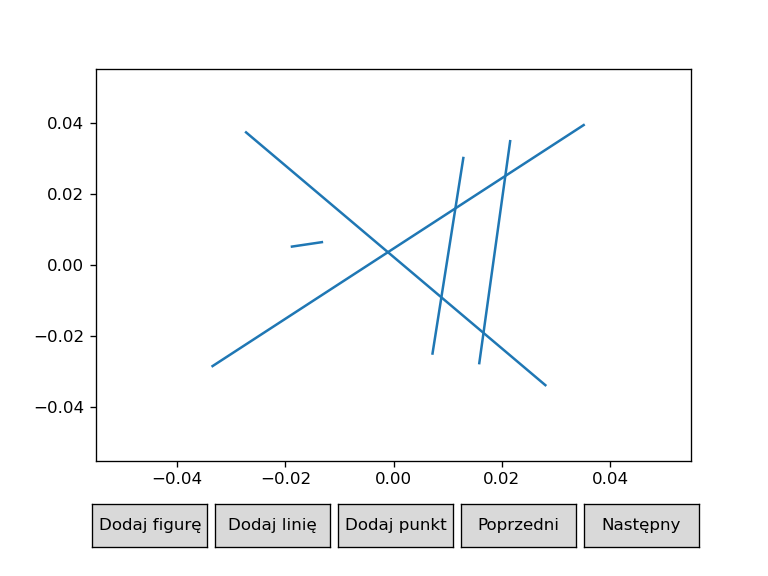

In [28]:
plot1 = Plot()
plot1.draw()


Number of intersections 5
Point (0.008828495643939852, -0.009089986287508336)
Line ((0.007155682963709678, -0.02522203164832533), (0.012921811995967744, 0.030384585998733504)) ((-0.02744109122983871, 0.03746179188108645), (0.028224231350806456, -0.03398428655028612))
Point (0.020646659257187644, 0.025000092358635005)
Line ((-0.03365076864919355, -0.028592129687541018), (0.03532100554435484, 0.03948385070461587)) ((0.015804876512096777, -0.027918110079697883), (0.021571005544354843, 0.03510272325363546))
Point (0.01661335928399378, -0.019081807989413353)
Line ((0.015804876512096777, -0.027918110079697883), (0.021571005544354843, 0.03510272325363546)) ((-0.02744109122983871, 0.03746179188108645), (0.028224231350806456, -0.03398428655028612))
Point (0.011419035819160804, 0.015892315741630386)
Line ((-0.03365076864919355, -0.028592129687541018), (0.03532100554435484, 0.03948385070461587)) ((0.007155682963709678, -0.02522203164832533), (0.012921811995967744, 0.030384585998733504))
Point (-0

<IPython.core.display.Javascript object>


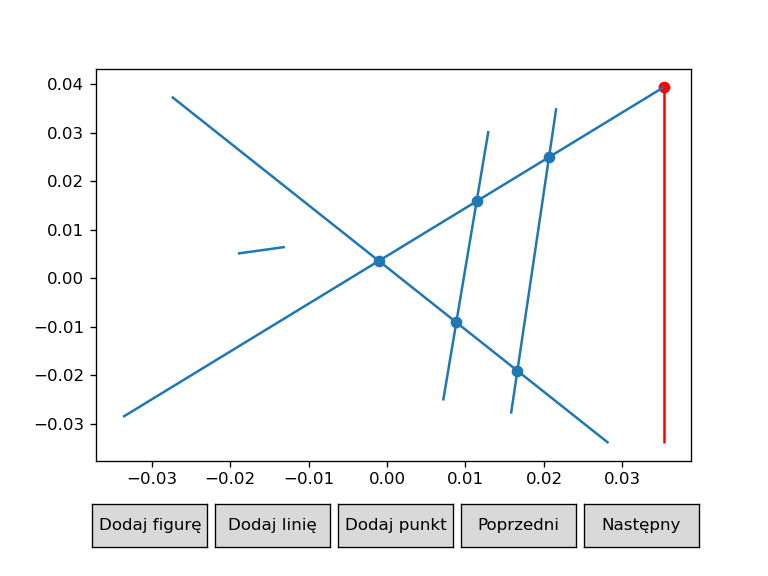

In [29]:
%matplotlib notebook
scenes = []
sweep = findIntersections(scenes)
dataset = get_lines(plot1)
result = sweep.start(dataset)
print('Number of intersections ' + str(len(result)))
for p in result:
    print('Point ' + str(p))
    print('Line ' + str(p.line1) + ' ' + str(p.line2))
plot = Plot(scenes)
plot.draw()